In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

grid_size = 100
test_states = torch.tensor([[50.,50.]])
test_scores = torch.tensor([-150.0])
n_samples = 5

baseline_states = torch.tensor([[ 0,  7],
        [ 1, 41],
        [43,  0],
        [83, 84]])

# define grid space
xi = np.arange(0,1,1/grid_size)
yi = np.arange(0,1,1/grid_size)
grid = np.array(np.meshgrid(xi,yi))
grid_flat = torch.tensor(grid.T, dtype=torch.float64).reshape(-1,2).to(device)
    

In [2]:
import matplotlib.pyplot as plt

def plot_function(fn, space, fig=None, ax=None, scatter_markers=None, output_index=-1):
    # fn: function to plot
    # output_index: -1 if the output of the function is a single value; if the outputs are tuples index of the output that should be plotted
    res = fn(space)
    if output_index >= 0:
        res = res[output_index]
    res = res.to("cpu").detach()
    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows=1)
    # ax.matshow(res)
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py
    cntr = ax.contourf(xi, yi, res.reshape(int(len(res)**(1/2)),int(len(res)**(1/2))), levels=50)
    fig.colorbar(cntr, ax=ax)
    if scatter_markers is not None:
        scatter_markers = scatter_markers
        ax.scatter(x=scatter_markers[:,0], y=scatter_markers[:,1], c="red", marker="x")
    return fig, ax

In [3]:
# dataset
from dataset.dataset import BraninDatasetHandler
dataset_handler = BraninDatasetHandler(train_path="./storage/branin/data_train.csv", train_fraction=1.0, float_precision=64)

# testing dataset
dataset_handler.update_dataset(test_states, test_scores)
print(dataset_handler.train_data.X_data, dataset_handler.train_data.y_data)
print(dataset_handler.train_data[:])
train_loader, test_loader = dataset_handler.get_dataloader()
for X, y in train_loader:
    print(X, y)

TODO: check what format the states and scores have and make sure that everything is stored in the same format
tensor([[ 0.0000,  7.0000],
        [ 1.0000, 41.0000],
        [43.0000,  0.0000],
        [83.0000, 84.0000],
        [ 0.5000,  0.5000]], dtype=torch.float64) tensor([-272.7960, -122.4223,  -25.6283, -141.9208, -150.0000],
       dtype=torch.float64)
(tensor([[0.0000, 0.0700],
        [0.0100, 0.4100],
        [0.4300, 0.0000],
        [0.8300, 0.8400],
        [0.0050, 0.0050]], dtype=torch.float64), tensor([0.0000, 0.6084, 1.0000, 0.5295, 0.4968], dtype=torch.float64))
tensor([[0.0050, 0.0050],
        [0.0000, 0.0700],
        [0.8300, 0.8400],
        [0.4300, 0.0000],
        [0.0100, 0.4100]], dtype=torch.float64) [tensor(0.4968, dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0.5295, dtype=torch.float64), tensor(1., dtype=torch.float64), tensor(0.6084, dtype=torch.float64)]


tensor([0.3584], device='cuda:0', dtype=torch.float64) tensor([0.1824], device='cuda:0', dtype=torch.float64)


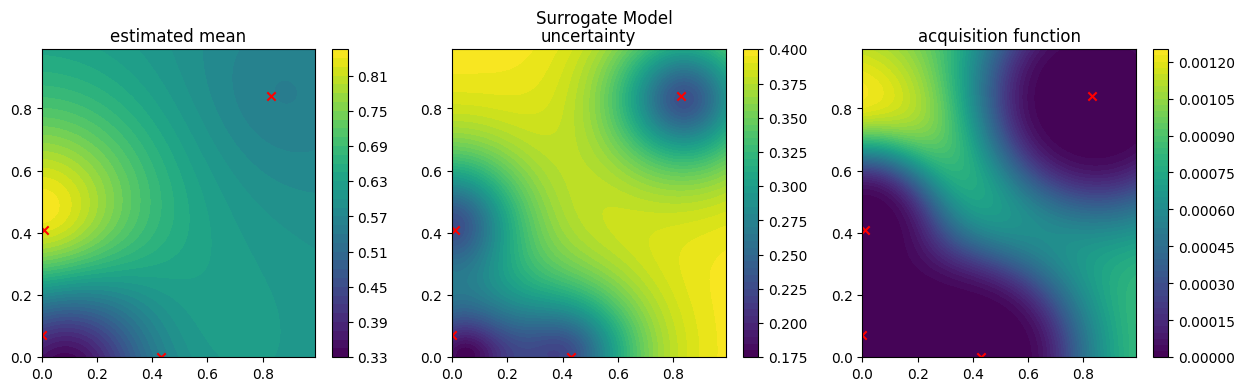

In [4]:
# Surrogate (e.g., Bayesian Optimization)
from surrogate.surrogate import SingleTaskGPRegressor
surrogate = SingleTaskGPRegressor(device=device)
surrogate.fit(dataset_handler.train_data)

# testing surrogate
preds_mean, preds_var = surrogate.get_predictions(test_states/grid_size)
print(preds_mean, preds_var)

# plot surrogate functions
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

plot_function(surrogate.get_predictions, grid_flat.clone(), fig=fig, ax=axes[0], scatter_markers=baseline_states/grid_size, output_index=0)
axes[0].set_title("estimated mean")

plot_function(surrogate.get_predictions, grid_flat.clone(), fig=fig, ax=axes[1], scatter_markers=baseline_states/grid_size, output_index=1)
axes[1].set_title("uncertainty")

plot_function(surrogate.get_acquisition_values, grid_flat.clone(), fig=fig, ax=axes[2], scatter_markers=baseline_states/grid_size)
axes[2].set_title("acquisition function")

fig.suptitle("Surrogate Model")
plt.show()

In [5]:
# Sampler (e.g., GFlowNet, or Random Sampler)
from sampler.sampler import Sampler, RandomSampler
# sampler = Sampler(surrogate)
sampler = RandomSampler(surrogate)
# sampler.fit()
samples = sampler.get_samples(n_samples*5, grid_flat.clone())

tensor([ -35.8619, -185.1583, -282.1307, -167.8297], device='cuda:0',
       dtype=torch.float64)


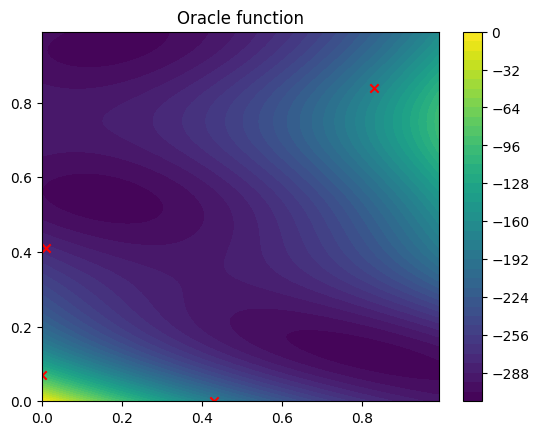

In [6]:
# Oracle
from gflownet.proxy.box.branin import Branin
oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=64)

# testing oracle
print(oracle(baseline_states.to(device).clone()/grid_size))

# plot oracle function
plot_function(oracle, grid_flat.clone(), scatter_markers=baseline_states/grid_size)
plt.title("Oracle function")
plt.show()

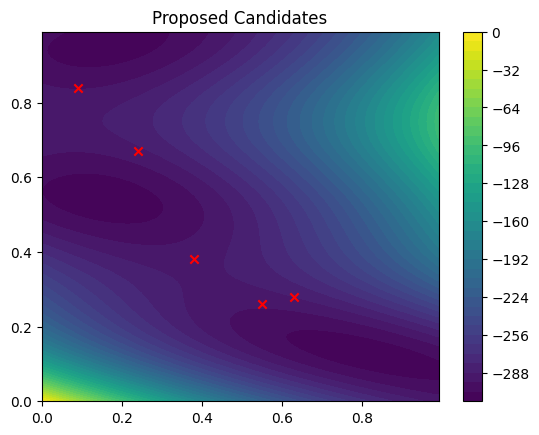

In [8]:
from filter.filter import Filter, OracleFilter

# filter = Filter()
filter = OracleFilter(oracle)
filtered_samples = filter(n_samples, samples)

# plot oracle function with proposed candidates
plot_function(oracle, grid_flat.clone(), scatter_markers=filtered_samples.to("cpu"))
plt.title("Proposed Candidates")
plt.show()

In [9]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

abs_config_dir=os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

# Logger
from utils.logger import Logger
logger = Logger(
    config=OmegaConf.create(), 
    **config_logger
)

{'do': {'online': True, 'times': True}, 'ckpts': {'policy': {'period': 5000}, 'regressor': {'period': 10}}, 'train': {'period': 1}, 'test': {'period': -1, 'n': 1, 'first_it': True, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}}, 'oracle': {'period': -1, 'k': [1, 10, 100]}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'data': 'data', 'overwrite': True}, 'lightweight': False, 'progress': True, 'debug': False, 'project_name': 'MF-AL-GFN', 'tags': ['branin', 'sf']}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christina-humer. Use `wandb login --relogin` to force relogin


# Active Learning Loop

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

n_iterations = 5 # TODO: replace with budget
grid_size = 10
float_prec = 64
n_samples = 5
# define candidate set
xi = np.arange(0,1,1/grid_size)
yi = np.arange(0,1,1/grid_size)
grid = np.array(np.meshgrid(xi,yi))
grid_flat = torch.tensor(grid.T, dtype=torch.float64).reshape(-1,2).to(device)
from dataset.dataset import Branin_Data
candidate_set, _ = Branin_Data(grid_flat, grid_size=grid_size, device=device)[:]

In [2]:
from dataset.dataset import BraninDatasetHandler
from surrogate.surrogate import SingleTaskGPRegressor
from sampler.sampler import Sampler, RandomSampler
from filter.filter import Filter, OracleFilter
from gflownet.proxy.box.branin import Branin


# Dataset
dataset_handler = BraninDatasetHandler(train_path="./storage/branin/data_train.csv", train_fraction=1.0, device=device, float_precision=float_prec)
# Oracle
oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=float_prec)
# Filter
filter = OracleFilter(oracle)

for i in range(n_iterations):
    print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate = SingleTaskGPRegressor(float_precision=float_prec, device=device)
    surrogate.fit(dataset_handler.train_data)
    
    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    sampler = RandomSampler(surrogate)
    sampler.fit() # only necessary for samplers that train a model

    samples = sampler.get_samples(n_samples*5, candidate_set=candidate_set.clone())
    filtered_samples = filter(n_samples=n_samples, candidate_set=candidate_set.clone(), maximize=False)

    dataset_handler.update_dataset(candidate_set, oracle(candidate_set.clone()))


iteration 0
TODO: check what format the states and scores have and make sure that everything is stored in the same format
iteration 1
TODO: check what format the states and scores have and make sure that everything is stored in the same format
iteration 2
TODO: check what format the states and scores have and make sure that everything is stored in the same format
iteration 3
TODO: check what format the states and scores have and make sure that everything is stored in the same format
iteration 4
TODO: check what format the states and scores have and make sure that everything is stored in the same format


In [8]:
dataset_handler.train_data.y_data

tensor([-2.7280e+02, -1.2242e+02, -2.5628e+01, -1.4192e+02, -4.8806e+02,
        -1.7569e+03, -3.0147e+03, -4.2613e+03, -5.4969e+03, -6.7213e+03,
        -7.9345e+03, -9.1367e+03, -1.0328e+04, -1.1508e+04, -4.4401e+03,
        -5.6772e+03, -6.9031e+03, -8.1179e+03, -9.3215e+03, -1.0514e+04,
        -1.1695e+04, -1.2866e+04, -1.4025e+04, -1.5173e+04, -8.2614e+03,
        -9.4670e+03, -1.0661e+04, -1.1845e+04, -1.3017e+04, -1.4178e+04,
        -1.5328e+04, -1.6467e+04, -1.7595e+04, -1.8711e+04, -1.1947e+04,
        -1.3122e+04, -1.4286e+04, -1.5438e+04, -1.6579e+04, -1.7709e+04,
        -1.8828e+04, -1.9936e+04, -2.1033e+04, -2.2119e+04, -1.5494e+04,
        -1.6638e+04, -1.7771e+04, -1.8893e+04, -2.0003e+04, -2.1103e+04,
        -2.2191e+04, -2.3269e+04, -2.4335e+04, -2.5390e+04, -1.8897e+04,
        -2.0011e+04, -2.1113e+04, -2.2205e+04, -2.3286e+04, -2.4355e+04,
        -2.5413e+04, -2.6461e+04, -2.7497e+04, -2.8522e+04, -2.2152e+04,
        -2.3236e+04, -2.4309e+04, -2.5371e+04, -2.6

In [ ]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer, 
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)